In [49]:
import torch
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import sctokenizer
import spacy
import string
import re
from collections import Counter

import random
import torch
import torch.nn as nn
import torch.nn.init as weight_init
import torch.nn.functional as F
#from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader
from torch import optim

In [2]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1660 Ti'

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
df = pd.read_csv("E:/BITS/2nd Year/Industry project/Dataset/c_data_twocols.zip")

In [5]:
df = df.replace(r'^\s*$', np.nan, regex=True)

In [6]:
df.head()

,code,comment
0,struct _CameraFile {\n char\t\tmime_typ...,NaN
1,struct _CameraFilesystem {\n\tCameraFilesystem...,The internals of the #CameraFilesystem are onl...
2,struct _CameraWidget {\n\tCameraWidgetType typ...,CameraWidget: The internals of the #CameraWidg...
3,struct _entry {\n\tchar *name;\n\tchar *value;...,NaN
4,\tchar error[2048];\t/**< Internal kept error ...,Internal kept error message.


In [7]:
df = df.dropna(axis=0)

In [8]:
df['code'] = df['code'].astype('str')
df['comment'] = df['comment'].astype('str')

In [9]:
df_train = df.head(10000)

In [10]:
from sctokenizer import CppTokenizer

ctokenizer = CppTokenizer()

In [11]:
from spacy.lang.en.stop_words import STOP_WORDS

spacy_nlp = spacy.load('en_core_web_sm')

punctuations = string.punctuation
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [12]:
def spacy_tokenizer(sentence):
 
    #remove distracting single quotes
    sentence = re.sub('\'','',sentence)

    #remove digits adnd words containing digits
    sentence = re.sub('\w*\d\w*','',sentence)

    #replace extra spaces with single space
    sentence = re.sub(' +',' ',sentence)

    #remove unwanted lines starting from special charcters
    sentence = re.sub(r'\n: \'\'.*','',sentence)
    sentence = re.sub(r'\n!.*','',sentence)
    sentence = re.sub(r'^:\'\'.*','',sentence)
    
    #remove non-breaking new line characters
    sentence = re.sub(r'\n',' ',sentence)
    
    #remove punctunations
    sentence = re.sub(r'[^\w\s]',' ',sentence)
    
    #creating token object
    tokens = spacy_nlp(sentence)
    
    #lower, strip and lemmatize
    tokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens]
    
    #remove stopwords, and exclude words less than 2 characters
    tokens = [word for word in tokens if word not in stop_words and word not in punctuations and len(word) > 2]
    
    #return tokens
    return tokens

In [13]:
def str_code(x):
    tokens = ctokenizer.tokenize(x)
    string_tok = [str(i.token_value)+" "+str(i.token_type) for i in tokens]
    return string_tok

In [14]:
str_code(df_train.iat[0,0])

['struct TokenType.KEYWORD',
 '_ TokenType.SPECIAL_SYMBOL',
 'CameraFilesystem TokenType.IDENTIFIER',
 '{ TokenType.SPECIAL_SYMBOL',
 'CameraFilesystemFolder TokenType.IDENTIFIER',
 '* TokenType.OPERATOR',
 'rootfolder TokenType.IDENTIFIER',
 '; TokenType.SPECIAL_SYMBOL',
 'CameraFilesystemFile TokenType.IDENTIFIER',
 '* TokenType.OPERATOR',
 'lru_first TokenType.IDENTIFIER',
 '; TokenType.SPECIAL_SYMBOL',
 'CameraFilesystemFile TokenType.IDENTIFIER',
 '* TokenType.OPERATOR',
 'lru_last TokenType.IDENTIFIER',
 '; TokenType.SPECIAL_SYMBOL',
 'unsigned TokenType.KEYWORD',
 'long TokenType.KEYWORD',
 'int TokenType.KEYWORD',
 'lru_size TokenType.IDENTIFIER',
 '; TokenType.SPECIAL_SYMBOL',
 'CameraFilesystemGetInfoFunc TokenType.IDENTIFIER',
 'get_info_func TokenType.IDENTIFIER',
 '; TokenType.SPECIAL_SYMBOL',
 'CameraFilesystemSetInfoFunc TokenType.IDENTIFIER',
 'set_info_func TokenType.IDENTIFIER',
 '; TokenType.SPECIAL_SYMBOL',
 'CameraFilesystemListFunc TokenType.IDENTIFIER',
 'file_li

In [15]:
df_train['comment_token'] = df_train['comment'].map(lambda x: spacy_tokenizer(x))
df_train['code_token'] = df_train['code'].map(lambda x: str_code(x))

In [16]:
df_train.head()

,code,comment,comment_token,code_token
1,struct _CameraFilesystem {\n\tCameraFilesystem...,The internals of the #CameraFilesystem are onl...,"[internal, camerafilesystem, visible, access, ...","[struct TokenType.KEYWORD, _ TokenType.SPECIAL..."
2,struct _CameraWidget {\n\tCameraWidgetType typ...,CameraWidget: The internals of the #CameraWidg...,"[camerawidget, internal, camerawidget, visible...","[struct TokenType.KEYWORD, _ TokenType.SPECIAL..."
4,\tchar error[2048];\t/**< Internal kept error ...,Internal kept error message.,"[internal, error, message]","[char TokenType.KEYWORD, error TokenType.KEYWO..."
5,\tstruct _GPPortInfo info;\t/**< Internal port...,Internal port information of this port.,"[internal, port, information, port]","[struct TokenType.KEYWORD, _ TokenType.SPECIAL..."
6,\tGPPortOperations *ops;\t/**< Internal port o...,Internal port operations.,"[internal, port, operation]","[GPPortOperations TokenType.IDENTIFIER, * Toke..."


In [17]:
counts_com = Counter()
for index, row in df_train.iterrows():
    counts_com.update(row['comment_token'])

In [18]:
print("num_words before:",len(counts_com.keys()))
for word in list(counts_com):
    if counts_com[word] < 2:
        del counts_com[word]
print("num_words after:",len(counts_com.keys()))

num_words before: 6881
num_words after: 3435


In [19]:
counts_code = Counter()
for index, row in df_train.iterrows():
    counts_code.update(row['code_token'])

In [20]:
print("num_words before:",len(counts_code.keys()))
for word in list(counts_code):
    if counts_code[word] < 2:
        del counts_code[word]
print("num_words after:",len(counts_code.keys()))

num_words before: 44062
num_words after: 25180


In [21]:
vocab2index_com = {"":0, "UNK":1}
words_com = ["", "UNK"]
for word in counts_com:
    vocab2index_com[word] = len(words_com)
    words_com.append(word)

In [22]:
vocab2index_code = {"":0, "UNK":1}
words_code = ["", "UNK"]
for word in counts_code:
    vocab2index_code[word] = len(words_code)
    words_code.append(word)

In [23]:
l_com = []
for index, row in df_train.iterrows():
    l_com.append(len(row['comment_token']))
print(f"Mean = {np.mean(l_com)}")
print(f"Median = {np.median(l_com)}")
print(f"Max = {np.max(l_com)}")

Mean = 10.3102
Median = 6.0
Max = 375


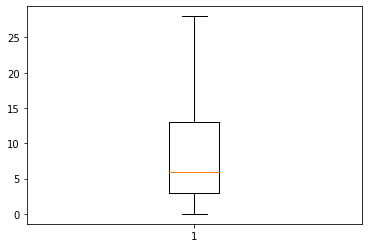

In [24]:
import matplotlib.pyplot as plt

plt.boxplot(l_com, showfliers=False)

plt.show()

In [25]:
l_code = []
for index, row in df_train.iterrows():
    l_code.append(len(row['code_token']))
print(f"Mean = {np.mean(l_code)}")
print(f"Median = {np.median(l_code)}")
print(f"Max = {np.max(l_code)}")



Mean = 156.7234
Median = 80.0
Max = 5554


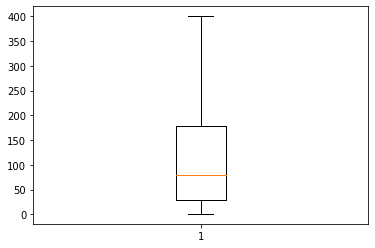

In [26]:
import matplotlib.pyplot as plt

plt.boxplot(l_code, showfliers=False)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


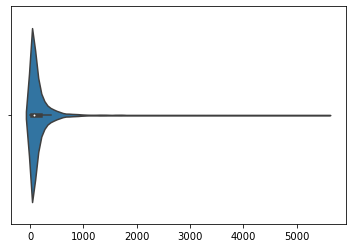

In [27]:
import seaborn as sns

ax = sns.violinplot(l_code, showextrema=False)

In [28]:
def encode_sentence(tokenized, vocab2index, N=25):
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

In [29]:
def encode_code(tokenized, vocab2index, N=400):
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

In [30]:
df_train['comment_vec'] = df_train['comment_token'].apply(lambda x: np.array(encode_sentence(x,vocab2index_com )))
df_train['code_vec'] = df_train['code_token'].apply(lambda x: np.array(encode_code(x,vocab2index_code )))

<ipython-input-30-de7353da255d>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  df_train['comment_vec'] = df_train['comment_token'].apply(lambda x: np.array(encode_sentence(x,vocab2index_com )))
<ipython-input-30-de7353da255d>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  df_train['code_vec'] = df_train['code_token'].apply(lambda x: np.array(encode_code(x,vocab2index_code )))


In [31]:
df_train.head()

,code,comment,comment_token,code_token,comment_vec,code_vec
1,struct _CameraFilesystem {\n\tCameraFilesystem...,The internals of the #CameraFilesystem are onl...,"[internal, camerafilesystem, visible, access, ...","[struct TokenType.KEYWORD, _ TokenType.SPECIAL...","[[2, 3, 4, 5, 6, 7, 8, 0, 0, 0, 0, 0, 0, 0, 0,...","[[2, 3, 4, 5, 1, 6, 7, 8, 9, 6, 1, 8, 9, 6, 1,..."
2,struct _CameraWidget {\n\tCameraWidgetType typ...,CameraWidget: The internals of the #CameraWidg...,"[camerawidget, internal, camerawidget, visible...","[struct TokenType.KEYWORD, _ TokenType.SPECIAL...","[[9, 2, 9, 4, 5, 6, 7, 8, 0, 0, 0, 0, 0, 0, 0,...","[[2, 3, 29, 5, 30, 31, 8, 32, 33, 34, 35, 36, ..."
4,\tchar error[2048];\t/**< Internal kept error ...,Internal kept error message.,"[internal, error, message]","[char TokenType.KEYWORD, error TokenType.KEYWO...","[[2, 10, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[32, 58, 34, 59, 36, 8, 41, 42, 0, 0, 0, 0, 0..."
5,\tstruct _GPPortInfo info;\t/**< Internal port...,Internal port information of this port.,"[internal, port, information, port]","[struct TokenType.KEYWORD, _ TokenType.SPECIAL...","[[2, 12, 13, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[2, 3, 60, 37, 8, 41, 42, 0, 0, 0, 0, 0, 0, 0..."
6,\tGPPortOperations *ops;\t/**< Internal port o...,Internal port operations.,"[internal, port, operation]","[GPPortOperations TokenType.IDENTIFIER, * Toke...","[[2, 12, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[61, 6, 62, 8, 41, 42, 0, 0, 0, 0, 0, 0, 0, 0..."


In [94]:
code = []
comment = []
for index,row in df_train.iterrows():
    code.append((row['code_vec'])[0])
    comment.append((row['comment_vec'])[0])

In [95]:
code_len = np.array(code[0].shape)
comment_len = np.array(comment[0].shape)

In [96]:
class SeqEncoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, n_layers=1):
        super(SeqEncoder, self).__init__()
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=0)
        self.lstm = nn.LSTM(emb_size, hidden_size, batch_first=True, bidirectional=True)
        self.init_weights()
        
    def init_weights(self):
        nn.init.uniform_(self.embedding.weight, -0.1, 0.1)
        nn.init.constant_(self.embedding.weight[0], 0)
        for name, param in self.lstm.named_parameters():
            if 'weight' in name or 'bias' in name: 
                param.data.uniform_(-0.1, 0.1)

    def forward(self, inputs, input_lens=None): 
        '''
        input_lens: [batch_size]
        '''
        batch_size, seq_len=inputs.size()
        inputs = self.embedding(inputs)  # input: [batch_sz x seq_len]  embedded: [batch_sz x seq_len x emb_sz]
        inputs = F.dropout(inputs, 0.25, self.training)
        
        #if input_lens is not None:# sort and pack sequence 
        #    input_lens_sorted, indices = input_lens.sort(descending=True)
        #    inputs_sorted = inputs.index_select(0, indices)        
        #    inputs = pack_padded_sequence(inputs_sorted, input_lens_sorted.data.tolist(), batch_first=True)
            
        hids, (h_n, c_n) = self.lstm(inputs)  
        
        #if input_lens is not None: # reorder and pad
        #    _, inv_indices = indices.sort()
        #    hids, lens = pad_packed_sequence(hids, batch_first=True) # hids:[batch_size x seq_len x (n_dir*hid_sz)](biRNN)
        #    hids = F.dropout(hids, p=0.25, training=self.training)
        #    hids = hids.index_select(0, inv_indices)
        #    h_n = h_n.index_select(1, inv_indices)
        h_n = h_n.view(self.n_layers, 2, batch_size, self.hidden_size) #[n_layers x n_dirs x batch_sz x hid_sz]
        h_n = h_n[-1] 
        encoding3 = torch.cat((h_n[0], h_n[1]), dim=1)
        return encoding3 

In [97]:
class BOWEncoder(nn.Module):
  
    def __init__(self, vocab_size, emb_size, hidden_size):
        super(BOWEncoder, self).__init__()
        self.emb_size=emb_size
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, emb_size)
        
        self.init_weights()
        
    def init_weights(self):
        nn.init.uniform_(self.embedding.weight, -0.1, 0.1)
        nn.init.constant_(self.embedding.weight[0], 0)
        
    def forward(self, input, input_len=None): 
        batch_size, seq_len =input.size()
        embedded = self.embedding(input)  
        embedded= F.dropout(embedded, 0.25, self.training) 
        maxpooling = nn.MaxPool1d(kernel_size = seq_len, stride=seq_len)
        output_pool = maxpooling(embedded.transpose(1,2)).squeeze(2) 
        encoding = output_pool
        return encoding

In [98]:
class JointEmbedder(nn.Module):

    def __init__(self):
        super(JointEmbedder, self).__init__()
        self.margin = 0.04
               
        
        self.code_encoder=BOWEncoder(25200,512,512)
        self.comment_encoder=SeqEncoder(3500,512,1024)

        
        self.w_code = nn.Linear(512, 512)
        self.w_comment = nn.Linear(2*1024, 512)
        
        self.init_weights()
        
    def init_weights(self):# Initialize Linear Weight 
        for m in [self.w_code]:        
            m.weight.data.uniform_(-0.1, 0.1)#nn.init.xavier_normal_(m.weight)
            nn.init.constant_(m.bias, 0.) 
            
    def code_encoding(self, code_tokens, code_len):
        code_repr=self.code_encoder(code_tokens, code_len)
        code_repr = self.w_code(code_repr)
        return code_repr
        
    def comment_encoding(self, comment, comment_len):
        comment_repr=self.comment_encoder(comment, comment_len)
        comment_repr=self.w_comment(comment_repr)
        return comment_repr
    
    def similarity(self, code_vec, comment_vec):
   
            return F.cosine_similarity(code_vec, comment_vec)
      
    
    def forward(self, code, code_len, comment_anchor, comment_anchor_len, comment_neg, comment_neg_len):
        batch_size=code.size(0)
        code_repr=self.code_encoding(code, code_len)
        comment_anchor_repr=self.comment_encoding(comment_anchor, comment_anchor_len)
        comment_neg_repr=self.comment_encoding(comment_neg, comment_neg_len)
    
        anchor_sim = self.similarity(code_repr, comment_anchor_repr)
        neg_sim = self.similarity(code_repr, comment_neg_repr) # [batch_sz x 1]
        
        #loss=(self.margin-anchor_sim+neg_sim).clamp(min=1e-6).mean()
        loss=(self.margin-anchor_sim+neg_sim).mean()
        
        return loss

In [99]:
model = JointEmbedder()


In [100]:
testcode = torch.from_numpy(np.array(code[3822:3823]))
testcomm = torch.from_numpy(np.array(comment[2822:2823]))
testnegcomm = torch.from_numpy(np.array(comment[12:13]))

In [101]:
model(testcode,code_len,testcomm,comment_len,testnegcomm,comment_len)

tensor(0.0200, grad_fn=<MeanBackward0>)

In [123]:
def train(data_loader):
    #optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)        
    #scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps,num_training_steps=len(data_loader)*epochs)
    optimizer = torch.optim.Adam(model.parameters())
    n_iters = len(data_loader)
    for epoch in range(1): 
       
        losses=[]
        i = 0
        for batch in data_loader:
            
            model.train()
            
            code,code_len,good,good_len,bad,bad_len = batch
            code = code.reshape(4,400).to(device)
            code_len = code_len.reshape(4).to(device)
            good = good.reshape(4,25).to(device)
            good_len = good_len.reshape(4).to(device)
            bad = bad.reshape(4,25).to(device)
            bad_len = bad_len.reshape(4).to(device)
            
            loss = model(code,code_len,good,good_len,bad,bad_len)
            
            #batch_gpu = [tensor.to(device) for tensor in batch]
            #loss = model(*batch_gpu)
            #loss = model(*batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #scheduler.step()
            model.zero_grad()
            losses.append(loss.item())
            print(loss.item())

In [124]:
class CodeSearchDataset(Dataset):
    def __init__(self, code, code_len, comment=None, comment_len=None):
        
        self.code = code
        self.code_len = code_len
        self.data_len = len(code)
        self.comment = comment
        self.comment_len = comment_len
        
    def __getitem__(self, idx):
        
        cd = torch.from_numpy(self.code[idx])
        cd = cd.unsqueeze(dim=0)
        cd_len = torch.from_numpy(self.code_len)
        
        #if self.training:
        good_desc = torch.from_numpy(self.comment[idx])
        good_desc = good_desc.unsqueeze(dim=0)
        good_desc_len = torch.from_numpy(self.comment_len)
            
        rand_idx=random.randint(0, self.data_len-1)
            
        bad_desc = torch.from_numpy(self.comment[rand_idx])
        bad_desc = bad_desc.unsqueeze(dim=0)
        bad_desc_len = torch.from_numpy(self.comment_len)
            
        return cd, cd_len, good_desc, good_desc_len, bad_desc, bad_desc_len
        #return cd, code_len
    
    def __len__(self):
        return(self.data_len)

In [125]:
dataset = CodeSearchDataset(code, code_len, comment, comment_len)

In [126]:
data_loader = DataLoader(dataset, batch_size=4, collate_fn=None)

In [127]:
model.to(device)

JointEmbedder(
  (code_encoder): BOWEncoder(
    (embedding): Embedding(25200, 512)
  )
  (comment_encoder): SeqEncoder(
    (embedding): Embedding(3500, 512, padding_idx=0)
    (lstm): LSTM(512, 1024, batch_first=True, bidirectional=True)
  )
  (w_code): Linear(in_features=512, out_features=512, bias=True)
  (w_comment): Linear(in_features=2048, out_features=512, bias=True)
)

In [128]:
train(data_loader)

0.04138115420937538
-0.06684549152851105
0.023296505212783813
0.019599393010139465
0.09012585878372192
0.029692113399505615
0.040961652994155884
0.02663421630859375
-0.013870049268007278
-0.2095385491847992
0.03785748779773712
0.03769819438457489
0.03344970941543579
0.027875855565071106
0.023244038224220276
-0.001421809196472168
-0.06102681905031204
0.026511773467063904
0.014690995216369629
-0.024357616901397705
-0.023637697100639343
-0.11037586629390717
-0.10225553065538406
-0.21456195414066315
-0.0401817187666893
-0.017394326627254486
-0.23027387261390686
0.015544533729553223
0.04135839641094208
-0.14514955878257751
0.05835244059562683
-0.12665940821170807
-0.0725211575627327
-0.026525065302848816
0.033131495118141174
0.04564063251018524
0.026301175355911255
0.033472463488578796
0.03625090420246124
0.0331571102142334
0.025489047169685364
0.038264140486717224
0.05704447627067566
0.02698814868927002
-0.0021094083786010742
-0.004134148359298706
0.004736050963401794
0.03693234920501709
0

-0.45727163553237915
0.039485588669776917
0.0430617481470108
-0.9553228616714478
0.040765225887298584
0.04031616449356079
0.03994877636432648
0.03994269669055939
0.04033450782299042
0.03996896743774414
-0.45936906337738037
0.5395090579986572
-0.9590588212013245
0.039778947830200195
0.03951098024845123
-0.46000075340270996
-0.4591701626777649
0.03966057300567627
-0.9593271017074585
-0.4595394730567932
0.04026520252227783
0.03960028290748596
-0.459173321723938
-0.4585762023925781
1.0371428728103638
-0.9583680629730225
0.04024107754230499
0.04023751616477966
-0.4596399664878845
-0.4594581127166748
-1.458615779876709
-0.46044713258743286
-0.9592158198356628
-0.460825115442276
0.039951980113983154
-0.459622859954834
-0.46175140142440796
-0.45979857444763184
0.04009249806404114
0.03983666002750397
-0.45771893858909607
0.041171953082084656
-0.4586948752403259
0.04156601428985596
0.5392962694168091
0.5394005179405212
0.03970165550708771
0.03971239924430847
-0.9587007164955139
-0.45881858468055

-1.4507430791854858
-1.9416582584381104
-1.9488356113433838
-1.9517656564712524
-0.9568289518356323
0.03956221044063568
-1.4560339450836182
-1.4572484493255615
-1.9567148685455322
-1.9563652276992798
-0.48338210582733154
-0.45948922634124756
-0.9495956897735596
-1.457348346710205
-0.9353615641593933
-0.9685438275337219
-0.44138795137405396
-0.9131826162338257
-0.9295846223831177
-0.9357846975326538
0.03877897560596466
-1.9024434089660645
-0.9293048977851868
-0.9316350221633911
-0.4400579333305359
0.03741303086280823
-0.44452476501464844
0.03891158103942871
0.038924574851989746
-0.4437987506389618
-0.932914137840271
-0.4469751715660095
0.039499059319496155
-0.9411180019378662
-0.9399992227554321
-0.4527457356452942
0.5326290130615234
-1.438834309577942
1.0238299369812012
-0.9487361907958984
0.5350248217582703
0.041019290685653687
0.039654165506362915
-0.9519795179367065
0.03752332925796509
1.5287055969238281
0.5373152494430542
1.5274063348770142
1.0340635776519775
0.5366355776786804
1.0

-0.9228577017784119
-1.4092257022857666
0.07527226209640503
0.020147591829299927
-0.45911863446235657
-0.9563553333282471
-0.4569876194000244
-0.47652068734169006
-0.453532338142395
-1.4349489212036133
-0.44800376892089844
-0.4414651095867157
-0.4433482885360718
0.039669767022132874
0.5363054871559143
-0.9544468522071838
-0.9475643634796143
-0.457694947719574
-0.9363759756088257
1.017258882522583
0.5347705483436584
2.0384323596954346
1.0378800630569458
0.542209267616272
-0.955602765083313
0.037437379360198975
1.0380228757858276
-0.45932966470718384
-0.4597785472869873
0.5395594835281372
-0.958828330039978
-0.9594509601593018
0.5370798707008362
-0.957950234413147
-1.4579488039016724
-0.4606708884239197
0.5385915040969849
1.0115430355072021
0.5372682213783264
-1.4575645923614502
0.5355124473571777
0.03918325901031494
0.5103355646133423
1.0089999437332153
-0.4595227837562561
0.04064510762691498
-1.455885887145996
1.0345066785812378
0.03780961036682129
-0.9576235413551331
0.038788840174674

-0.016748934984207153
0.0257883220911026
-0.9938835501670837
-0.023224011063575745
0.4241809844970703
0.07099463045597076
0.012974441051483154
-0.045136794447898865
-0.43126675486564636
0.020278483629226685
-0.3756159543991089
0.029231145977973938
-0.37338462471961975
-0.28979557752609253
-0.5088388919830322
0.04128137230873108
0.7204157114028931
0.442548543214798
0.5210549831390381
0.5029928684234619
-0.48063117265701294
1.4488482475280762
-0.07814884185791016
-0.5110591053962708
-0.5481308698654175
0.009074151515960693
-0.15481048822402954
0.3338860273361206
0.40451425313949585
0.38424521684646606
-0.10826383531093597
-0.34276890754699707
-0.3764287233352661
-0.5051509141921997
0.19630351662635803
-0.19761115312576294
-0.14297732710838318
0.4624488949775696
-0.06595949083566666
-0.038399435579776764
-0.09873135387897491
-0.4605402648448944
-0.3769090175628662
-0.05477572977542877
-0.16426490247249603
0.04876142740249634
0.17150558531284332
0.10765621066093445
0.34252357482910156
0.00

-0.8435773849487305
-1.0531789064407349
-1.3696141242980957
-0.9204176664352417
-1.2230212688446045
-1.5940954685211182
-0.515119194984436
-0.9533014893531799
-1.488442063331604
-1.7860655784606934
-1.3675241470336914
-0.9294655323028564
-0.9491544961929321
-0.49285247921943665
-1.6693761348724365
-0.8987308740615845
-1.3751205205917358
-0.4499002993106842
-0.45457732677459717
-0.2867473363876343
0.9689056277275085
-0.44933655858039856
-0.9817055463790894
-1.4197227954864502
-1.1204161643981934
-1.3156362771987915
-1.1051822900772095
0.03999277949333191
0.41460224986076355
-0.6274595260620117
-0.7793713212013245
-1.104055404663086
-1.1036615371704102
-0.4039459228515625
-0.9629207253456116
-0.14471852779388428
-0.9634565114974976
-0.25978225469589233
-0.9771565198898315
-1.0407389402389526
-0.3286418318748474
-0.9571486115455627
-1.202962875366211
-1.2115825414657593
-0.3615579605102539
-0.996208906173706
-0.9876164197921753
-0.9723899960517883
-1.508004903793335
-1.3865978717803955
-0

0.04031150043010712
0.07418939471244812
0.042328596115112305
0.04357483983039856
0.03269781172275543
0.03998139500617981
0.043414101004600525
0.04602152109146118
0.04272632300853729
0.037659525871276855
0.04058556258678436
0.04200753569602966
0.04761531949043274
0.047237515449523926
0.04134523868560791
0.026974186301231384
0.04099251329898834
0.03997848927974701
0.02506856620311737
0.042361870408058167
0.023808658123016357
0.04529742896556854
0.04989592730998993
0.034641578793525696
0.017759472131729126
0.034187063574790955
0.04971618950366974
0.03479434549808502
0.04189059138298035
0.03361682593822479
0.045046210289001465
0.04923902451992035
0.030288442969322205
0.03580969572067261
0.030071735382080078
0.016309276223182678
0.03285767138004303
0.02947770059108734
0.04324369132518768
0.04632820188999176
0.03901877999305725
0.03471836447715759
0.034703344106674194
